In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from collections import Counter
from torchvision import models
import torch.optim as optim
from tqdm import tqdm
import os
import shutil

In [ ]:
source_path = 'C:/Users/Afreen khan/OneDrive/Desktop/Images Folder'
folder_names = ['hungry', 'belly_pain', 'burping', 'discomfort', 'tired']
destination_path = 'C:/Users/Afreen khan/OneDrive/Desktop/dataset'
for split in ['train', 'test']:
    for folder in folder_names:
        os.makedirs(os.path.join(destination_path, split, folder), exist_ok=True)
def load_images_from_folders(source_path, folder_names):
    image_paths = []
    labels = []
    for label, folder_name in enumerate(folder_names):
        folder_path = os.path.join(source_path, folder_name)
        for filename in os.listdir(folder_path):
            if filename.endswith('.png') or filename.endswith('.jpg'):
                image_paths.append(os.path.join(folder_path, filename))
                labels.append(label)
    return image_paths, labels
image_paths, labels = load_images_from_folders(source_path, folder_names)
X_train, X_test, Y_train, Y_test = train_test_split(image_paths, labels, train_size=0.8, stratify=labels)
def copy_files(file_list, labels_list, split):
    for file, label in zip(file_list, labels_list):
        class_name = folder_names[label]
        dest_folder = os.path.join(destination_path, split, class_name)
        shutil.copy(file, dest_folder)
copy_files(X_train, Y_train, 'train')
copy_files(X_test, Y_test, 'test')
print("Data has been successfully organized into train and test folders.")

Data has been successfully organized into train and test folders.


In [4]:
def read_audio(conf, pathname, trim_long_data):
    try:
        y, sr = librosa.load(pathname, sr=conf.sampling_rate)
        if len(y) > 0:
            y, _ = librosa.effects.trim(y)
        if len(y) > conf.samples: 
            if trim_long_data:
                y = y[:conf.samples]
            else:
                padding = conf.samples - len(y)
                offset = padding // 2
                y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
        return y, sr 
    except Exception as e:
        print(f"Error reading audio file: {e}")
        return None, None

In [5]:
def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(
        audio,
        sr=conf.sampling_rate,
        n_mels=conf.n_mels,
        hop_length=conf.hop_length,
        n_fft=conf.n_fft,
        fmin=conf.fmin,
        fmax=conf.fmax
    )
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

In [6]:
class Conf:
    sampling_rate = 16000
    duration = 7
    hop_length = 100 * duration
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration

In [7]:
def rename_file(img_name):
    img_name = img_name.split("/")[-1]
    img_name = img_name[:-4]  
    img_name += ".jpg" 
    return img_name 

In [8]:
def save_image_from_sound(audio_path, save_path):
    y, sr = librosa.load(audio_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    image_filename = os.path.join(save_path, os.path.basename(audio_path).replace('.wav', '.png'))
    plt.savefig(image_filename)
    plt.close()

In [9]:
def save_image_from_sound(audio_path, save_path):
    try:
        print(f"Loading audio: {audio_path}")
        y, sr = librosa.load(audio_path, sr=None)
        if y is None or len(y) == 0:
            print(f"Audio data is empty for: {audio_path}")
            return
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram')
        plt.tight_layout()
        image_filename = os.path.join(save_path, os.path.basename(audio_path).replace('.wav', '.png'))
        plt.savefig(image_filename)
        plt.close()
        print(f"Saved image: {image_filename}")
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
source_folders = ['hungry', 'belly_pain', 'burping', 'discomfort', 'tired']
source_path = 'C:/Users/Afreen khan/Downloads/donateacry_corpus'
destination_base_path = 'C:/Users/Afreen khan/OneDrive/Desktop/Images Folder'
for source_folder in source_folders:
    source_folder_path = os.path.join(source_path, source_folder)
    if os.path.isdir(source_folder_path):
        destination_folder_path = os.path.join(destination_base_path, source_folder)
        if not os.path.exists(destination_folder_path):
            os.makedirs(destination_folder_path)
        for fn in os.listdir(source_folder_path):
            file_path = os.path.join(source_folder_path, fn)
            if os.path.isfile(file_path):
                print(f"Processing file: {file_path}")
                save_image_from_sound(file_path, destination_folder_path)

Processing file: C:/Users/Afreen khan/Downloads/donateacry_corpus\hungry\02c3b725-26e4-4a2c-9336-04ddc58836d9-1430726196216-1.7-m-04-hu.wav
Loading audio: C:/Users/Afreen khan/Downloads/donateacry_corpus\hungry\02c3b725-26e4-4a2c-9336-04ddc58836d9-1430726196216-1.7-m-04-hu.wav
Saved image: C:/Users/Afreen khan/OneDrive/Desktop/Images Folder\hungry\02c3b725-26e4-4a2c-9336-04ddc58836d9-1430726196216-1.7-m-04-hu.png
Processing file: C:/Users/Afreen khan/Downloads/donateacry_corpus\hungry\02ead89b-aa02-453e-8b83-6ebde9fe7551-1430233132879-1.7-m-26-hu.wav
Loading audio: C:/Users/Afreen khan/Downloads/donateacry_corpus\hungry\02ead89b-aa02-453e-8b83-6ebde9fe7551-1430233132879-1.7-m-26-hu.wav
Saved image: C:/Users/Afreen khan/OneDrive/Desktop/Images Folder\hungry\02ead89b-aa02-453e-8b83-6ebde9fe7551-1430233132879-1.7-m-26-hu.png
Processing file: C:/Users/Afreen khan/Downloads/donateacry_corpus\hungry\035c6b30-a145-42b9-8d0f-445cd9003d2c-1435948197257-1.7-m-04-hu.wav
Loading audio: C:/Users/Af

In [10]:
def load_images_from_folders(source_path, folder_names):
    images = []
    labels = []    
    for folder_name in folder_names:
        folder_path = os.path.join(source_path, folder_name)
        if os.path.isdir(folder_path):
            print(f"Loading images from folder: {folder_name}")
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                if os.path.isfile(file_path) and filename.endswith('.png'):
                    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    image = cv2.resize(image, (128, 128))
                    images.append(image)
                    labels.append(folder_name)
    return images, labels
source_path = 'C:/Users/Afreen khan/OneDrive/Desktop/Images Folder'
folder_names = ['hungry', 'belly_pain', 'burping', 'discomfort', 'tired']
all_img, all_img_label = load_images_from_folders(source_path, folder_names)
if len(all_img) == 0 or len(all_img_label) == 0:
    raise ValueError("No images or labels found. Check the data loading process.")
X_train, X_test, Y_train, Y_test = train_test_split(all_img, all_img_label, train_size=0.8)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
print(f"Training Set: {X_train.shape}, {Y_train.shape}")
print(f"Test Set: {X_test.shape}, {Y_test.shape}")
train_label_counts = Counter(Y_train)
print("Training Set Label Distribution:")
for label, count in train_label_counts.items():
    print(f"{label}: {count} images")
test_label_counts = Counter(Y_test)
print("Test Set Label Distribution:")
for label, count in test_label_counts.items():
    print(f"{label}: {count} images")
print("First label in the training set:", Y_train[0])

Loading images from folder: hungry
Loading images from folder: belly_pain
Loading images from folder: burping
Loading images from folder: discomfort
Loading images from folder: tired
Training Set: (365, 128, 128), (365,)
Test Set: (92, 128, 128), (92,)
Training Set Label Distribution:
hungry: 306 images
discomfort: 22 images
tired: 18 images
burping: 6 images
belly_pain: 13 images
Test Set Label Distribution:
hungry: 76 images
belly_pain: 3 images
burping: 2 images
tired: 6 images
discomfort: 5 images
First label in the training set: hungry


In [11]:
def print_layer_info(model, input_tensor):
    print("Layer Parameters and Output Shapes:")
    hooks = []
    def hook_fn(module, input, output):
        num_params = sum(p.numel() for p in module.parameters())
        output_shape = output.shape
        print(f"{module.__class__.__name__.ljust(20)} | "
              f"Parameters: {num_params:>10} | "
              f"Output Shape: {str(output_shape):<20}")
    for layer in model.children():
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)
    with torch.no_grad():
        model(input_tensor)
    for hook in hooks:
        hook.remove()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dummy_input = torch.randn(1, 3, 128, 128).to(device)

c:\Users\Afreen khan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Afreen khan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50: 100%|██████████| 12/12 [02:09<00:00, 10.79s/it]


Epoch [1/50], Loss: 0.7962, Train Accuracy: 79.73%
Test Loss: 0.6950, Test Accuracy: 83.70%


Epoch 2/50: 100%|██████████| 12/12 [02:06<00:00, 10.54s/it]


Epoch [2/50], Loss: 0.7476, Train Accuracy: 83.56%
Test Loss: 0.6741, Test Accuracy: 83.70%


Epoch 3/50: 100%|██████████| 12/12 [02:03<00:00, 10.30s/it]


Epoch [3/50], Loss: 0.6771, Train Accuracy: 83.56%
Test Loss: 0.6614, Test Accuracy: 83.70%


Epoch 4/50: 100%|██████████| 12/12 [02:04<00:00, 10.36s/it]


Epoch [4/50], Loss: 0.7232, Train Accuracy: 83.56%
Test Loss: 0.6685, Test Accuracy: 83.70%


Epoch 5/50: 100%|██████████| 12/12 [02:04<00:00, 10.37s/it]


Epoch [5/50], Loss: 0.6666, Train Accuracy: 83.56%
Test Loss: 0.6553, Test Accuracy: 83.70%


Epoch 6/50: 100%|██████████| 12/12 [02:02<00:00, 10.22s/it]


Epoch [6/50], Loss: 0.6665, Train Accuracy: 83.56%
Test Loss: 0.6598, Test Accuracy: 83.70%


Epoch 7/50: 100%|██████████| 12/12 [02:04<00:00, 10.38s/it]


Epoch [7/50], Loss: 0.7042, Train Accuracy: 83.56%
Test Loss: 0.6583, Test Accuracy: 83.70%


Epoch 8/50: 100%|██████████| 12/12 [02:01<00:00, 10.13s/it]


Epoch [8/50], Loss: 0.6581, Train Accuracy: 83.56%
Test Loss: 0.6551, Test Accuracy: 83.70%


Epoch 9/50: 100%|██████████| 12/12 [02:02<00:00, 10.21s/it]


Epoch [9/50], Loss: 0.6539, Train Accuracy: 83.56%
Test Loss: 0.6816, Test Accuracy: 83.70%


Epoch 10/50: 100%|██████████| 12/12 [01:37<00:00,  8.14s/it]


Epoch [10/50], Loss: 0.7029, Train Accuracy: 83.56%
Test Loss: 0.6595, Test Accuracy: 83.70%


Epoch 11/50: 100%|██████████| 12/12 [00:52<00:00,  4.39s/it]


Epoch [11/50], Loss: 0.7221, Train Accuracy: 83.56%
Test Loss: 0.6789, Test Accuracy: 83.70%


Epoch 12/50: 100%|██████████| 12/12 [00:50<00:00,  4.24s/it]


Epoch [12/50], Loss: 0.6577, Train Accuracy: 83.56%
Test Loss: 0.6475, Test Accuracy: 83.70%


Epoch 13/50: 100%|██████████| 12/12 [00:52<00:00,  4.40s/it]


Epoch [13/50], Loss: 0.6603, Train Accuracy: 83.56%
Test Loss: 0.6595, Test Accuracy: 83.70%


Epoch 14/50: 100%|██████████| 12/12 [00:54<00:00,  4.58s/it]


Epoch [14/50], Loss: 0.6424, Train Accuracy: 83.56%
Test Loss: 0.6393, Test Accuracy: 83.70%


Epoch 15/50: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]


Epoch [15/50], Loss: 0.6670, Train Accuracy: 83.56%
Test Loss: 0.6522, Test Accuracy: 83.70%


Epoch 16/50: 100%|██████████| 12/12 [00:54<00:00,  4.53s/it]


Epoch [16/50], Loss: 0.6495, Train Accuracy: 83.56%
Test Loss: 0.6810, Test Accuracy: 83.70%


Epoch 17/50: 100%|██████████| 12/12 [00:54<00:00,  4.57s/it]


Epoch [17/50], Loss: 0.6554, Train Accuracy: 83.56%
Test Loss: 0.6792, Test Accuracy: 83.70%


Epoch 18/50: 100%|██████████| 12/12 [00:55<00:00,  4.59s/it]


Epoch [18/50], Loss: 0.6630, Train Accuracy: 83.56%
Test Loss: 0.6547, Test Accuracy: 83.70%


Epoch 19/50: 100%|██████████| 12/12 [00:55<00:00,  4.66s/it]


Epoch [19/50], Loss: 0.6707, Train Accuracy: 83.56%
Test Loss: 0.6633, Test Accuracy: 83.70%


Epoch 20/50: 100%|██████████| 12/12 [00:54<00:00,  4.56s/it]


Epoch [20/50], Loss: 0.6398, Train Accuracy: 83.56%
Test Loss: 0.6735, Test Accuracy: 83.70%


Epoch 21/50: 100%|██████████| 12/12 [01:05<00:00,  5.44s/it]


Epoch [21/50], Loss: 0.6503, Train Accuracy: 83.56%
Test Loss: 0.6334, Test Accuracy: 83.70%


Epoch 22/50: 100%|██████████| 12/12 [00:54<00:00,  4.58s/it]


Epoch [22/50], Loss: 0.6366, Train Accuracy: 83.56%
Test Loss: 0.6519, Test Accuracy: 83.70%


Epoch 23/50: 100%|██████████| 12/12 [00:55<00:00,  4.61s/it]


Epoch [23/50], Loss: 0.6370, Train Accuracy: 83.56%
Test Loss: 0.6443, Test Accuracy: 83.70%


Epoch 24/50: 100%|██████████| 12/12 [00:55<00:00,  4.63s/it]


Epoch [24/50], Loss: 0.6412, Train Accuracy: 83.56%
Test Loss: 0.6748, Test Accuracy: 83.70%


Epoch 25/50: 100%|██████████| 12/12 [01:10<00:00,  5.87s/it]


Epoch [25/50], Loss: 0.6789, Train Accuracy: 83.56%
Test Loss: 0.6527, Test Accuracy: 83.70%


Epoch 26/50: 100%|██████████| 12/12 [01:06<00:00,  5.51s/it]


Epoch [26/50], Loss: 0.6708, Train Accuracy: 83.56%
Test Loss: 0.6750, Test Accuracy: 83.70%


Epoch 27/50: 100%|██████████| 12/12 [00:54<00:00,  4.55s/it]


Epoch [27/50], Loss: 0.6491, Train Accuracy: 83.56%
Test Loss: 0.6502, Test Accuracy: 83.70%


Epoch 28/50: 100%|██████████| 12/12 [00:54<00:00,  4.51s/it]


Epoch [28/50], Loss: 0.6862, Train Accuracy: 83.56%
Test Loss: 0.6845, Test Accuracy: 83.70%


Epoch 29/50: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]


Epoch [29/50], Loss: 0.6507, Train Accuracy: 83.56%
Test Loss: 0.6675, Test Accuracy: 83.70%


Epoch 30/50: 100%|██████████| 12/12 [00:57<00:00,  4.76s/it]


Epoch [30/50], Loss: 0.6975, Train Accuracy: 83.56%
Test Loss: 0.6651, Test Accuracy: 83.70%


Epoch 31/50: 100%|██████████| 12/12 [00:55<00:00,  4.62s/it]


Epoch [31/50], Loss: 0.6431, Train Accuracy: 83.56%
Test Loss: 0.6581, Test Accuracy: 83.70%


Epoch 32/50: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]


Epoch [32/50], Loss: 0.6828, Train Accuracy: 83.56%
Test Loss: 0.6894, Test Accuracy: 83.70%


Epoch 33/50: 100%|██████████| 12/12 [00:55<00:00,  4.60s/it]


Epoch [33/50], Loss: 0.6810, Train Accuracy: 83.56%
Test Loss: 0.6657, Test Accuracy: 83.70%


Epoch 34/50: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]


Epoch [34/50], Loss: 0.6525, Train Accuracy: 83.56%
Test Loss: 0.6769, Test Accuracy: 83.70%


Epoch 35/50: 100%|██████████| 12/12 [00:56<00:00,  4.71s/it]


Epoch [35/50], Loss: 0.6281, Train Accuracy: 83.56%
Test Loss: 0.6886, Test Accuracy: 83.70%


Epoch 36/50: 100%|██████████| 12/12 [01:00<00:00,  5.05s/it]


Epoch [36/50], Loss: 0.6624, Train Accuracy: 83.56%
Test Loss: 0.6511, Test Accuracy: 83.70%


Epoch 37/50: 100%|██████████| 12/12 [01:00<00:00,  5.02s/it]


Epoch [37/50], Loss: 0.6175, Train Accuracy: 83.56%
Test Loss: 0.6764, Test Accuracy: 83.70%


Epoch 38/50: 100%|██████████| 12/12 [00:55<00:00,  4.60s/it]


Epoch [38/50], Loss: 0.6450, Train Accuracy: 83.56%
Test Loss: 0.6984, Test Accuracy: 83.70%


Epoch 39/50: 100%|██████████| 12/12 [01:00<00:00,  5.04s/it]


Epoch [39/50], Loss: 0.6452, Train Accuracy: 83.56%
Test Loss: 0.6522, Test Accuracy: 83.70%


Epoch 40/50: 100%|██████████| 12/12 [00:56<00:00,  4.70s/it]


Epoch [40/50], Loss: 0.6565, Train Accuracy: 83.56%
Test Loss: 0.6896, Test Accuracy: 83.70%


Epoch 41/50: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]


Epoch [41/50], Loss: 0.6207, Train Accuracy: 83.56%
Test Loss: 0.6845, Test Accuracy: 83.70%


Epoch 42/50: 100%|██████████| 12/12 [00:56<00:00,  4.69s/it]


Epoch [42/50], Loss: 0.6257, Train Accuracy: 83.56%
Test Loss: 0.6461, Test Accuracy: 83.70%


Epoch 43/50: 100%|██████████| 12/12 [00:57<00:00,  4.75s/it]


Epoch [43/50], Loss: 0.6253, Train Accuracy: 83.56%
Test Loss: 0.6728, Test Accuracy: 83.70%


Epoch 44/50: 100%|██████████| 12/12 [00:58<00:00,  4.86s/it]


Epoch [44/50], Loss: 0.6437, Train Accuracy: 83.56%
Test Loss: 0.6721, Test Accuracy: 83.70%


Epoch 45/50: 100%|██████████| 12/12 [00:57<00:00,  4.77s/it]


Epoch [45/50], Loss: 0.6518, Train Accuracy: 83.56%
Test Loss: 0.7040, Test Accuracy: 83.70%


Epoch 46/50: 100%|██████████| 12/12 [00:57<00:00,  4.78s/it]


Epoch [46/50], Loss: 0.6487, Train Accuracy: 83.56%
Test Loss: 0.6648, Test Accuracy: 83.70%


Epoch 47/50: 100%|██████████| 12/12 [00:55<00:00,  4.64s/it]


Epoch [47/50], Loss: 0.6529, Train Accuracy: 83.56%
Test Loss: 0.6652, Test Accuracy: 83.70%


Epoch 48/50: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]


Epoch [48/50], Loss: 0.6430, Train Accuracy: 83.56%
Test Loss: 0.6815, Test Accuracy: 83.70%


Epoch 49/50: 100%|██████████| 12/12 [00:54<00:00,  4.55s/it]


Epoch [49/50], Loss: 0.6418, Train Accuracy: 83.56%
Test Loss: 0.6585, Test Accuracy: 83.70%


Epoch 50/50: 100%|██████████| 12/12 [00:55<00:00,  4.65s/it]


Epoch [50/50], Loss: 0.6612, Train Accuracy: 83.56%
Test Loss: 0.6713, Test Accuracy: 83.70%
Best Test Accuracy: 83.70%


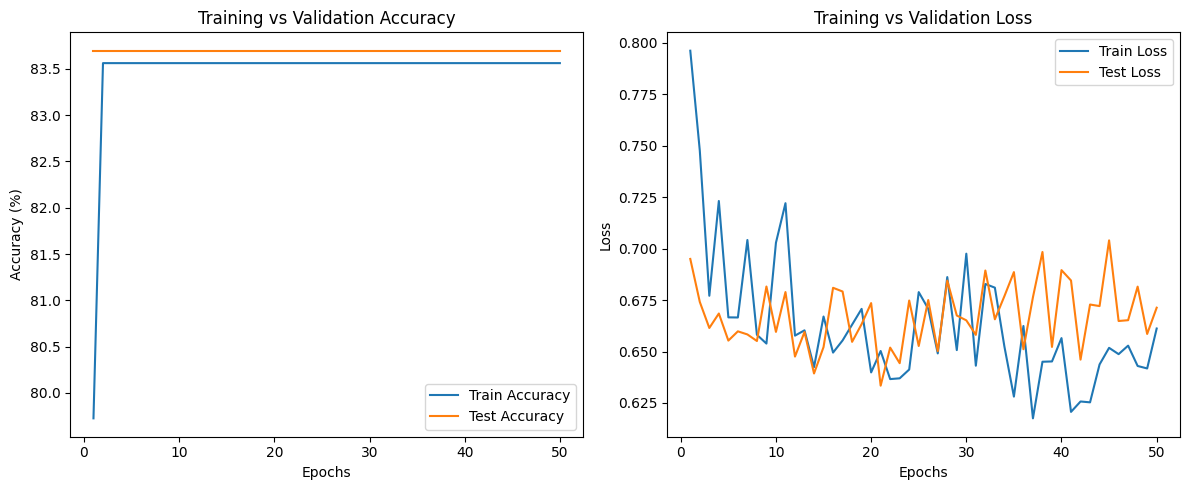

In [5]:
from torch.utils.data import Dataset
import cv2
import os
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
source_path = 'C:/Users/Afreen khan/OneDrive/Desktop/Images Folder'
folder_names = ['hungry', 'belly_pain', 'burping', 'discomfort', 'tired']
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (224, 224))
        if self.transform:
            image = self.transform(image)
        return image, label
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(15), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def load_images_from_folders(source_path, folder_names):
    image_paths = []
    labels = []
    for label, folder_name in enumerate(folder_names):
        folder_path = os.path.join(source_path, folder_name)
        for filename in os.listdir(folder_path):
            if filename.endswith('.png'):
                image_paths.append(os.path.join(folder_path, filename))
                labels.append(label)
    return image_paths, labels
image_paths, labels = load_images_from_folders(source_path, folder_names)
X_train, X_test, Y_train, Y_test = train_test_split(image_paths, labels, train_size=0.8, stratify=labels)
train_dataset = ImageDataset(X_train, Y_train, transform=transform)
test_dataset = ImageDataset(X_test, Y_test, transform=transform)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False
for param in model.layer3.parameters(): 
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
num_classes = len(folder_names)
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(model.fc.in_features, num_classes)
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)
num_epochs = 50
best_accuracy = 0.0
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_resnet50_model.pth')
print(f"Best Test Accuracy: {best_accuracy:.2f}%")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()